# Project 2 source code

In [34]:
# exercise 8.1.1
from sklearn.datasets import load_diabetes
import pandas as pd
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection
from dtuimldmtools import rlr_validate


# Load dataset from sklearn
X,y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Convert to pandas dataframe
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# # Standardize data
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Rename columns
X.rename(columns={'s1':'tc', 's2': 'ldl', 's3': 'hdl', 's4': 'tch', 's5': 'ltg', 's6': 'glu'}, inplace=True)

# Add Offset
X['Offset'] = 1

# Move offset to first position
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

# Number of samples and features: N = samples, M = features
N, M = X.shape

# attribute names
attributeNames = X.columns

# Convert pandas dataframe to numpy array
X = X.to_numpy()
y = y.to_numpy().flatten()

## Simple test

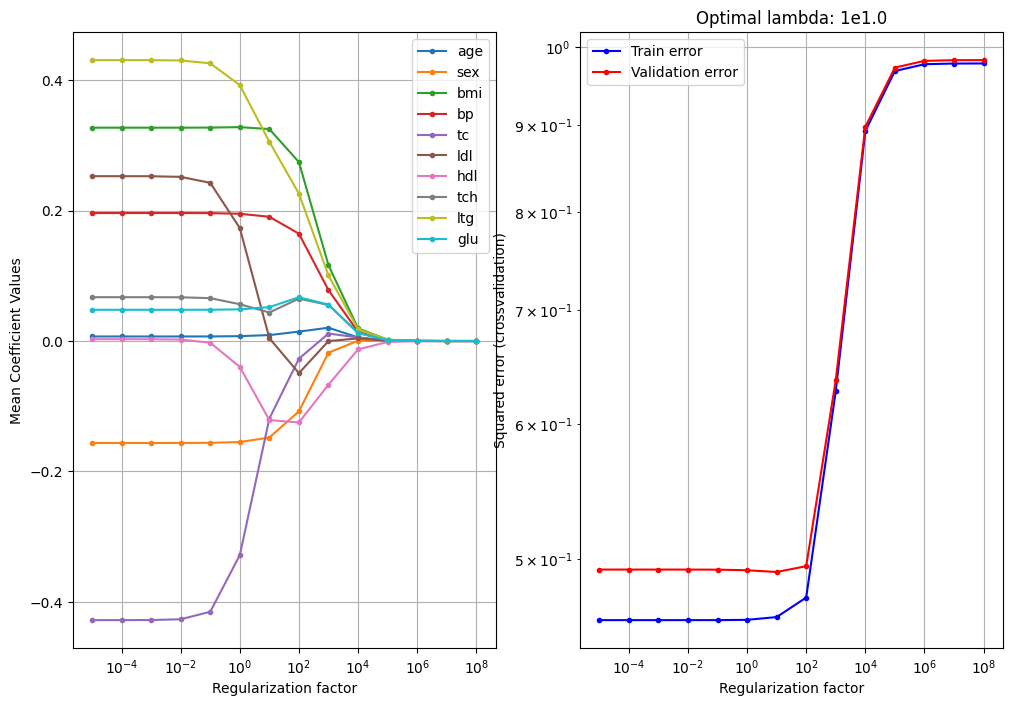

Linear regression without feature selection:
- Training error: 0.47958427743336485
- Test error:     0.5118067900488672
- R^2 train:     0.5192534330383004
- R^2 test:     0.48044347148039285

Regularized linear regression:
- Training error: 0.4809137713142861
- Test error:     0.5148346890962584
- R^2 train:     0.517920717081743
- R^2 test:     0.47736972422193974

Weights in last fold:
         Offset       -0.006457
            age        0.009055
            sex       -0.149096
            bmi        0.325569
             bp          0.1908
             tc       -0.127562
            ldl        0.011807
            hdl       -0.119097
            tch        0.043367
            ltg        0.309422
            glu         0.05194
Mean weights for optimal lambda across all folds:
         Offset            -0.0
            age            -0.0
            sex           -0.14
            bmi            0.32
             bp             0.2
             tc           -0.26
            ld

In [60]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)
np.random.seed(2)
# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 6)))


# Compute the mean weights across all folds
mean_w_rlr = np.mean(w_rlr, axis=1)

# Print the mean weights
print("Mean weights for optimal lambda across all folds:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(mean_w_rlr[m], 2)))
print("Ran Exercise 8.1.1")


In [59]:
mean_w_vs_lambda.T[:, 1:]
pd.set_option('display.float_format', '{:.6f}'.format)

table = pd.DataFrame(mean_w_vs_lambda.T[:, 1:], columns=attributeNames[1:])
table.iloc[6]

age    0.009115
sex   -0.148007
bmi    0.325036
bp     0.190566
tc    -0.118855
ldl    0.004328
hdl   -0.121285
tch    0.043730
ltg    0.305527
glu    0.052009
Name: 6, dtype: float64

### Linear Regression

lambda 1e-05 mean test error 0.029844293370842934
0.029844293370842934
lambda 0.0001 mean test error 0.019611591286957265
0.019611591286957265
lambda 0.001 mean test error 0.021932529658079146
0.019611591286957265
lambda 0.01 mean test error 0.02383664473891258
0.019611591286957265
lambda 0.1 mean test error 0.027527414634823798
0.019611591286957265
lambda 1.0 mean test error 0.13129761666059495
0.019611591286957265
lambda 10.0 mean test error 0.6901006579399109
0.019611591286957265
lambda 100.0 mean test error 0.9603649616241455
0.019611591286957265
lambda 1000.0 mean test error nan
0.019611591286957265
lambda 10000.0 mean test error nan
0.019611591286957265


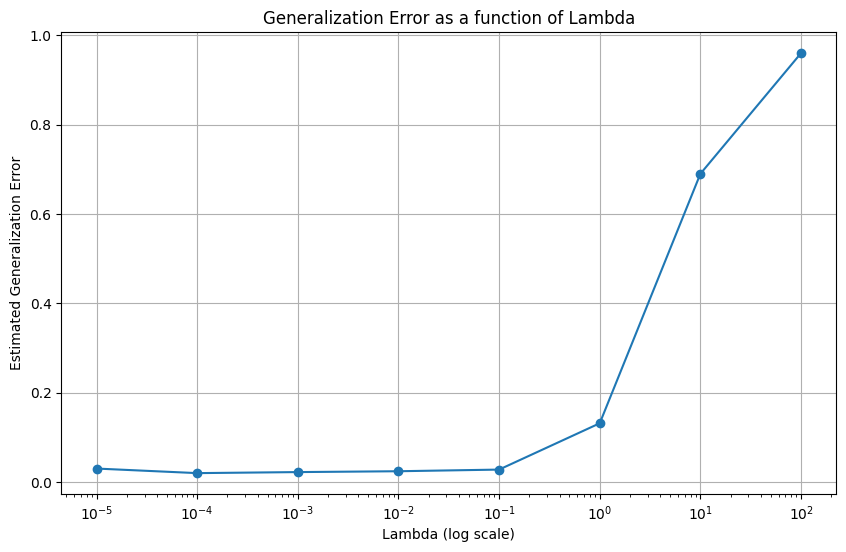

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

# 1. Define the Linear Regression model in PyTorch.
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # One output value

    def forward(self, x):
        return self.linear(x)

# 2. Generate some synthetic data for regression using scikit-learn
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=2)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))[:, 0]  # Standardize y and convert back to 1D array

# Convert the numpy arrays to PyTorch tensors
X_torch = torch.from_numpy(X.astype(np.float32))
y_torch = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

# 3. Set up the two-level cross-validation using scikit-learn's KFold for the outer and inner loops.
K1, K2 = 5, 5  # Number of folds in the outer and inner cross-validation loops respectively
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=2)
inner_cv = KFold(n_splits=K2, shuffle=True, random_state=2)

# Assume models is a list of your S different models
models = []

# Lists to store the final errors for each outer fold
test_errors = []
count = 0

# Define a range of lambda values
lambdas = np.power(10.0, range(-5, 5)) # Adjust this range based on your specific problem

# Lists to store the final errors for each lambda
lambda_errors = []

# Loop over lambda values
for lambda_ in lambdas:
    # Lists to store the final errors for each outer fold
    test_errors = []
    count = 0

    # Outer cross-validation loop
    for train_val_idx, test_idx in outer_cv.split(X_torch):
        X_train_val, X_test = X_torch[train_val_idx], X_torch[test_idx]
        y_train_val, y_test = y_torch[train_val_idx], y_torch[test_idx]

        # Define model, criterion and optimizer
        model = LinearRegressionModel(input_dim=X.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=lambda_)  # Apply L2 regularization

        # Train the model
        model.train()
        for epoch in range(100):  # Run for 100 epochs
            optimizer.zero_grad()
            outputs = model(X_train_val)
            loss = criterion(outputs, y_train_val)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            test_error = criterion(predictions, y_test).item()
            # print('lambda', lambda_, 'outer fold', count, test_error)
            count += 1
        test_errors.append(test_error)

    # Compute the mean test error across all outer folds
    mean_test_error = np.mean(test_errors)
    lambda_errors.append(mean_test_error)
    print('lambda', lambda_, 'mean test error', mean_test_error)
    print(min(lambda_errors))

# Plot the estimated generalization error as a function of lambda
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(lambdas, lambda_errors, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Estimated Generalization Error')
plt.title('Generalization Error as a function of Lambda')
plt.grid(True)
plt.show()